# Importing all the libraries required

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
!pip install -q -U keras-tuner
import kerastuner as kt
from tensorflow.keras import backend as K
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout,Conv2D, MaxPooling2D, ZeroPadding2D,Dropout
from tensorflow.keras.regularizers import l2

# GPU configuration

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Using Image data generator for data augmentation

In [4]:
img_width, img_height = 224, 224
TrainingImagePath = 'D:/University 3rd year/Artificial Intelligence and Robotics/Assigment/Ethnicity_dataset'
batch_size = 32

In [5]:

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.1,
        validation_split=0.2,
        rotation_range=5,
        horizontal_flip=True)
 

# Generating the Training Data
training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=True,
        subset='training',
        class_mode='categorical')
 
 
# Generating the Testing Data
test_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=True,
        subset = 'validation',
        class_mode='categorical')
 
# Printing class labels for each face
test_set.class_indices
#training_set.class_indices

Found 17536 images belonging to 4 classes.
Found 4382 images belonging to 4 classes.


{'African': 0, 'Asian': 1, 'Caucasian': 2, 'Indian': 3}

# Importing a pre-trained model from keras using the weights from imagenet

In [7]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
base_model=tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=input_shape,
    weights="imagenet"

)

for layer in base_model.layers:
        layer.trainable = False
        
        
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

#  Fine tunning the base model by createing the top layers required for training on this dataset useing keras tuner

In [8]:
def model_builder(hp):
    num_classes = 4
    dropout_rate_choice = hp.Float('rate', 0, .2, step=.1, default=.2)
    optimizer1=hp.Choice('optimizer1', values=['adam', 'adagrad', 'SGD'])
    
    # Conditional for each optimizer
    if optimizer1 == 'adam':
        optimization = tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-5, 1e-2, sampling='LOG', default=1e-3))
    elif optimizer1 == 'adagrad':
        optimization = tf.keras.optimizers.Adagrad(hp.Float('learning_rate', 1e-5, 1e-2, sampling='LOG', default=1e-3))
    elif optimizer1 == 'SGD':
        optimization = tf.keras.optimizers.SGD(hp.Float('learning_rate', 1e-5, 1e-2, sampling='LOG', default=1e-2))
        

                        
    base_input=base_model.layers[0].input
    base_output=base_model.layers[-1].output
    

    final_output=layers.Conv2D(hp.Int('units_base', min_value=32, max_value=512, step=32, default=128), kernel_size=(3,3), padding="same",kernel_regularizer=l2(hp.Float('regularizarer_rate_', 1e-5, 1e-2, sampling='LOG', default=1e-3)),name='conv_2d_base')(base_output)
    final_output=layers.BatchNormalization(name='batch_base')(final_output)
    final_output=tf.keras.layers.ReLU()(final_output)
    
    for i in range(hp.Int('num_layers_conv2d', 1, 2)):  # adding variation of layers.
         final_output=layers.Conv2D(hp.Int('units_conv2d_'+str(i), min_value=32, max_value=512, step=32, default=128), kernel_size=(3,3), padding="same",kernel_regularizer=l2(hp.Float('regularizarer_rate_', 1e-5, 1e-2, sampling='LOG', default=1e-3)),name='conv_2d_'+str(i))(final_output)
         final_output=layers.BatchNormalization(name='batch_1_'+str(i))(final_output)
         final_output=tf.keras.layers.ReLU()(final_output)

    final_output=layers.GlobalMaxPooling2D(data_format='channels_last')(final_output)
    
    final_output=layers.Dropout(rate=dropout_rate_choice)(final_output)
    final_output=layers.Flatten()(final_output)

  
    for i in range(hp.Int('num_layers_dense', 1, 2)):  # adding variation of layers.
         final_output=layers.Dense(hp.Int('units_dense_'+str(i), min_value=32, max_value=512, step=32, default=128),kernel_regularizer=l2(0.0001),name='dense_'+str(i))(final_output)
         final_output=layers.BatchNormalization(name='batch_2_'+str(i))(final_output)
         final_output=tf.keras.layers.ReLU()(final_output)

    final_output=layers.Dense(num_classes,activation='softmax')(final_output)


    new_model=tf.keras.Model(inputs=base_input,outputs=final_output)
    new_model.compile(optimizer=optimization, loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
    new_model.summary()
    return new_model

# Instantiate the tuner and perform hypertuning

In [9]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=6,
                     factor=3,
                     project_name='ethnicity_kt')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(training_set ,validation_data=test_set, epochs=10,callbacks=[stop_early])

Trial 30 Complete [00h 29m 26s]
val_loss: 5.065121650695801

Best val_loss So Far: 1.0171005725860596
Total elapsed time: 05h 59m 34s
INFO:tensorflow:Oracle triggered exit


In [11]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Training the model and saveing the it at the and of each epoch

In [12]:
model = tuner.hypermodel.build(best_hps)

directory='Checkpoint_ethnicity'
name='Model'
saved = os.path.join(directory, name + "-{epoch:02d}.h5")
callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=saved, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='min', save_freq='epoch'
)
history=model.fit(training_set,
        epochs=100,
        callbacks=callback,
        steps_per_epoch=17536 // batch_size,
        validation_data=test_set,
        validation_steps= 4382 // batch_size)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

Epoch 1/100
548/548 [==============================] - 183s 320ms/step - loss: 1.2364 - accuracy: 0.5084 - val_loss: 1.1182 - val_accuracy: 0.5570
Epoch 2/100
548/548 [==============================] - 173s 315ms/step - loss: 1.0739 - accuracy: 0.5904 - val_loss: 1.0822 - val_accuracy: 0.5758
Epoch 3/100
548/548 [==============================] - 172s 314ms/step - loss: 1.0224 - accuracy: 0.6194 - val_loss: 1.0529 - val_accuracy: 0.5880
Epoch 4/100
548/548 [==============================] - 172s 314ms/step - loss: 0.9907 - accuracy: 0.6357 - val_loss: 1.0288 - val_accuracy: 0.5963
Epoch 5/100
548/548 [==============================] - 171s 312ms/step - loss: 0.9656 - accuracy: 0.6462 - val_loss: 1.0076 - val_accuracy: 0.6128
Epoch 6/100
548/548 [==============================] - 172s 313ms/step - loss: 0.9355 - accuracy: 0.6621 - val_loss: 1.0402 - val_accuracy: 0.5997
Epoch 7/100
548/548 [==============================] - 172s 313ms/step - loss: 0.9135 - accuracy: 0.6712 - val_loss: 0

# Plotting the result

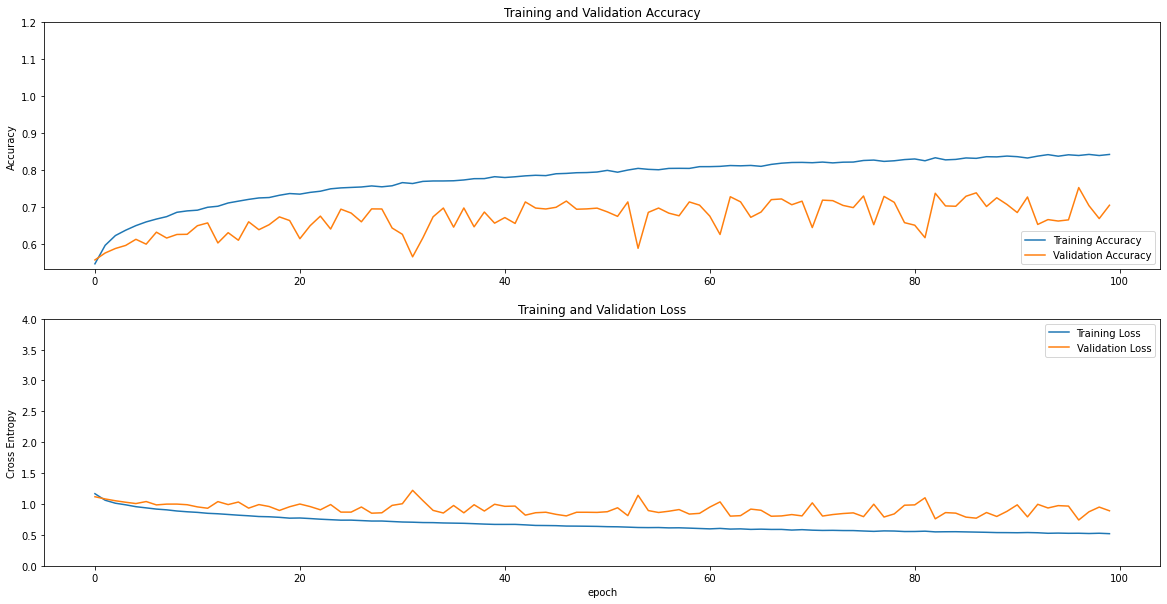

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.2])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()